In [1]:
from layers.attention import AttentionLayer
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow as tf
#import pytest

In [2]:
from tensorflow.keras.layers import GRU, Input

In [3]:

batch_size = 64
seq_length = 100
ndim = 6
hidden_size = 200 #latentSpaceDimension
hidden_size_decoder = hidden_size #in my case

n_timesteps_in = seq_length 
n_timesteps_out = n_timesteps_in #in my case
n_features = ndim
n_features_out = ndim #in my case

### Defining the input layers

In [4]:
encoder_inputs = Input(batch_shape=(batch_size, n_timesteps_in, n_features), name='encoder_inputs')
decoder_inputs = Input(batch_shape=(batch_size, n_timesteps_out-1, n_features_out), name='decoder_inputs') #nmt/model.py

### Defining the encoder 

In [5]:
encoder_gru = GRU(hidden_size, return_sequences=True, return_state=True, name='encoder_gru')

In [6]:
encoder_inputs, decoder_inputs

(<tf.Tensor 'encoder_inputs:0' shape=(64, 100, 6) dtype=float32>,
 <tf.Tensor 'decoder_inputs:0' shape=(64, 100, 6) dtype=float32>)

In [7]:
encoder_out, encoder_state = encoder_gru(encoder_inputs)

In [8]:
encoder_out, encoder_state

(<tf.Tensor 'encoder_gru/PartitionedCall:1' shape=(64, 100, 200) dtype=float32>,
 <tf.Tensor 'encoder_gru/PartitionedCall:2' shape=(64, 200) dtype=float32>)

### Defining the decoder

In [9]:
decoder_gru = GRU(hidden_size_decoder, return_sequences=True, return_state=True, name='decoder_gru')

In [10]:
decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

In [11]:
decoder_out, decoder_state

(<tf.Tensor 'decoder_gru/PartitionedCall:1' shape=(64, 100, 200) dtype=float32>,
 <tf.Tensor 'decoder_gru/PartitionedCall:2' shape=(64, 200) dtype=float32>)

### Defining the attention layer

In [12]:
attn_layer = AttentionLayer(name='attention_layer')

Inputs to the attention layer are encoder_out (sequence of encoder outputs) and decoder_out (sequence of decoder outputs)

In [13]:
attn_out, attn_states = attn_layer([encoder_out, decoder_out])

In [14]:
attn_out, attn_states

(<tf.Tensor 'attention_layer/transpose_5:0' shape=(64, 100, 200) dtype=float32>,
 <tf.Tensor 'attention_layer/transpose_3:0' shape=(64, 100, 100) dtype=float32>)

Concatenate the attn_out and decoder_out as an input to the softmax layer.

In [15]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

In [16]:
decoder_out, attn_out, decoder_concat_input

(<tf.Tensor 'decoder_gru/PartitionedCall:1' shape=(64, 100, 200) dtype=float32>,
 <tf.Tensor 'attention_layer/transpose_5:0' shape=(64, 100, 200) dtype=float32>,
 <tf.Tensor 'concat_layer/concat:0' shape=(64, 100, 400) dtype=float32>)

### Defining the TimeDistributed output layer

In [17]:
#dense = Dense(hidden_size_decoder, activation='softmax', name='softmax_layer')
dense = Dense(n_features_out, activation=None, name='softmax_layer')
dense_time = TimeDistributed(dense, name='time_distributed_layer')

In [18]:
decoder_pred = dense_time(decoder_concat_input)

In [22]:
decoder_concat_input, decoder_pred

(<tf.Tensor 'concat_layer/concat:0' shape=(64, 100, 400) dtype=float32>,
 <tf.Tensor 'time_distributed_layer/Reshape_1:0' shape=(64, 100, 6) dtype=float32>)

### Defining the full model

In [19]:
full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
full_model.compile(optimizer='adam', loss='categorical_crossentropy')

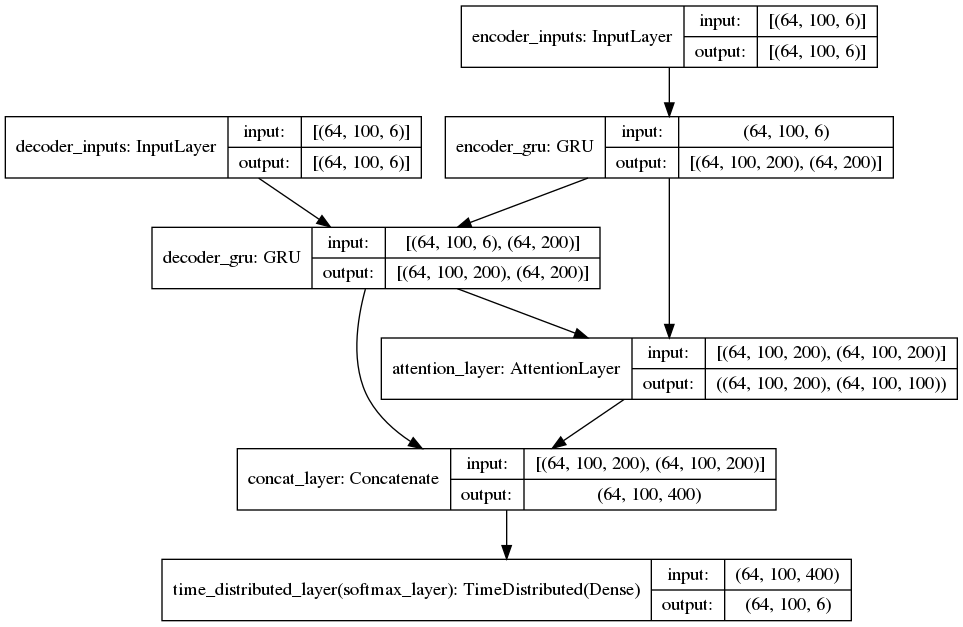

In [20]:
tf.keras.utils.plot_model(full_model, to_file="model_test.png", show_shapes=True)

### References
* Attention in Deep Networks with Keras, https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39